In [1]:
import warnings
warnings.filterwarnings("ignore")
from utils.dataset import TextDataset
from torch.utils.data import DataLoader
import torch.optim as optim
from torch import nn
import torch
from utils.model import LSTMnet_RnnAtten
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import pandas as pd
from copy import deepcopy

In [2]:
import os
print(os.getcwd())

train_annotations = '..\\data\\MELD\\train_sent_emo.csv'
val_annotations = '..\\data\\\MELD\\dev_sent_emo.csv'
test_annotations = '..\\data\\MELD\\test_sent_emo.csv'

train_bert = 'embeddings\\bert_embeddings'
val_bert = 'embeddings\\bert_embeddings_val'
test_bert = 'embeddings\\bert_embeddings_test'


c:\Users\kjart\OneDrive\Dokumenter\KU\2. semester\CogSci2\research\multimodal\text_only


In [3]:
l = False
train = TextDataset(train_annotations, train_bert, emotion=l, exclude=False)
val = TextDataset(val_annotations, val_bert, emotion=l, exclude=False)

# train, val = train_test_split(train, test_size=0.2)

train_dataloader = DataLoader(train, batch_size=64, shuffle = True, drop_last=False)
val_dataloader = DataLoader(val, batch_size=1000, shuffle=False, drop_last=False)
# train_features, train_labels = next(iter(train_dataloader))

In [4]:
print(len(train))

9989


In [5]:
# weights = torch.tensor([1-1109/9989, 1-271/9989, 1-268/9989, 1-1743/9989, 1-4710/9989, 1-683/9989, 1-1205/9989])
# emotions = {'anger':0, 'disgust':1, 'fear':2, 'joy':3, 'neutral':4, 'sadness':5, 'surprise':6}

In [6]:
# Sanity check: Size should be [batch_size, num_features, feature_vector_len], [batch_size]
# Where batch size is 32, num_features (num mfccs) is 40 
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
features = train_features[0]
label = train_labels

features.shape,label


Feature batch shape: torch.Size([64, 768])
Labels batch shape: torch.Size([64])


(torch.Size([768]),
 tensor([2, 2, 0, 1, 2, 2, 1, 0, 2, 2, 2, 1, 0, 2, 1, 2, 0, 0, 0, 2, 1, 1, 2, 0,
         2, 2, 1, 2, 2, 1, 2, 0, 0, 2, 2, 1, 2, 1, 0, 2, 0, 2, 2, 0, 1, 2, 2, 2,
         0, 1, 2, 1, 0, 0, 2, 1, 2, 0, 2, 2, 2, 2, 1, 1]))

In [7]:
for batch in train_dataloader:
    x, y = batch
    print(x.shape, y.shape)
    break
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# weight=torch.tensor([1-1109/9989, 1-271/9989, 1-268/9989, 1-1743/9989, 1-4710/9989, 1-683/9989, 1-1205/9989]).to(device=device)
weight=torch.tensor([1-2945/9989, 1-2334/9989, 1-4710/9989]).to(device=device)



torch.Size([64, 768]) torch.Size([64])


In [8]:
def loss_fnc(predictions, targets):
    return nn.CrossEntropyLoss(weight=weight, label_smoothing=0.01)(input=predictions,target=targets)

In [9]:
def make_train_step(model, loss_fnc, optimizer):
    def train_step(X,Y):
        # set model to train mode
        model.train()
        # forward pass
        output_logits = model(X)
        predictions = torch.argmax(output_logits,dim=1)
        accuracy = torch.sum(Y==predictions)/float(len(Y))
        f1 = f1_score(Y.cpu(), predictions.cpu(), average='weighted')
        # compute loss
        loss = loss_fnc(output_logits, Y)
        # compute gradients
        loss.backward()
        # update parameters and zero gradients
        optimizer.step()
        optimizer.zero_grad()
        return loss.item(), accuracy*100 , f1*100
    return train_step

In [10]:
def make_validate_fnc(model,loss_fnc):
    def validate(X,Y):
        with torch.no_grad():
            model.eval()
            output_logits = model(X)
            predictions = torch.argmax(output_logits,dim=1)
            accuracy = torch.sum(Y==predictions)/float(len(Y))
            f1 = f1_score(Y.cpu(), predictions.cpu(), average='weighted')
            loss = loss_fnc(output_logits,Y)
        return loss.item(), accuracy*100, predictions, f1*100
    return validate

In [11]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = LSTMnet_RnnAtten(input_dim = 768, hidden_dim=128, output_dim=3, num_layers=2, bidirectional=False).to(device)
print('Number of trainable params: ',sum(p.numel() for p in model.parameters()) )
OPTIMIZER = torch.optim.Adam(model.parameters(),lr=0.0001, weight_decay=1e-3)


Number of trainable params:  691203


In [12]:
train_step = make_train_step(model, loss_fnc, OPTIMIZER)
validate = make_validate_fnc(model,loss_fnc)

val_accs = []
losses=[]
val_losses = []
f1s = []
val_f1s= []
epochs = 120
best_val_f1 = 60


for epoch in range(epochs):
    epoch_acc = 0
    epoch_loss = 0
    epoch_f1 = 0
    for idx, (features, labels) in enumerate(train_dataloader):
        X, Y = features, labels
        X_tensor = torch.tensor(X,device=device).float()
        Y_tensor = torch.tensor(Y, dtype=torch.long,device=device)
        loss, acc, f1= train_step(X_tensor,Y_tensor)
        epoch_acc += acc*len(features)/len(train)
        epoch_loss += loss*len(features)/len(train)
        epoch_f1 += f1*len(features)/len(train)
    for batch in val_dataloader:
        X_val, Y_val = batch
        break
    X_val_tensor = torch.tensor(X_val,device=device).float()
    Y_val_tensor = torch.tensor(Y_val,dtype=torch.long,device=device)
    val_loss, val_acc, _, val_f1 = validate(X_val_tensor,Y_val_tensor)
    val_accs.append(val_acc.cpu())
    losses.append(epoch_loss)
    val_losses.append(val_loss)
    f1s.append(epoch_f1)
    val_f1s.append(val_f1)
    if val_f1 > best_val_f1:
        torch.save(deepcopy(model.state_dict()), 'best-model-params_sent_weighted1.pt')
        best_epoch = epoch
        best_val_f1 = val_loss
    
    print('')
    print(f"Epoch {epoch+1} --> loss:{epoch_loss:.4f}, acc:{epoch_acc:.2f}%, val_loss:{val_loss:.4f}, val_acc:{val_acc:.2f}%  f1:{f1:.2f}%, val_f1:{val_f1:.2f}")


Epoch 1 --> loss:1.0338, acc:49.12%, val_loss:0.9445, val_acc:58.00%  f1:88.57%, val_f1:57.88

Epoch 2 --> loss:0.9594, acc:57.45%, val_loss:0.8946, val_acc:59.40%  f1:57.14%, val_f1:59.48

Epoch 3 --> loss:0.9062, acc:61.19%, val_loss:0.8742, val_acc:62.10%  f1:10.00%, val_f1:61.56

Epoch 4 --> loss:0.8881, acc:62.42%, val_loss:0.8614, val_acc:62.70%  f1:100.00%, val_f1:62.50

Epoch 5 --> loss:0.8660, acc:63.83%, val_loss:0.8543, val_acc:63.20%  f1:74.67%, val_f1:62.84

Epoch 6 --> loss:0.8614, acc:63.97%, val_loss:0.8487, val_acc:63.00%  f1:100.00%, val_f1:62.45

Epoch 7 --> loss:0.8507, acc:64.75%, val_loss:0.8509, val_acc:63.30%  f1:68.00%, val_f1:62.87

Epoch 8 --> loss:0.8434, acc:65.51%, val_loss:0.8402, val_acc:64.70%  f1:60.00%, val_f1:64.24

Epoch 9 --> loss:0.8338, acc:65.55%, val_loss:0.8445, val_acc:63.60%  f1:30.00%, val_f1:63.09

Epoch 10 --> loss:0.8260, acc:66.09%, val_loss:0.8376, val_acc:63.90%  f1:73.33%, val_f1:63.76

Epoch 11 --> loss:0.8111, acc:66.91%, val_loss

layers:  2
model hidden dim:  128
batch size:  64
1.1946756839752197


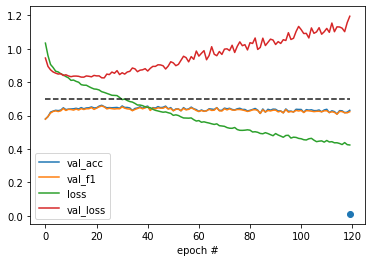

In [13]:
import matplotlib.pyplot as plt
x = range(epochs)

fig, ax = plt.subplots()
ax.set_xlabel('epoch #')
ax.set_ylabel('')
ax.plot(x,np.divide(val_accs,100), label='val_acc')
ax.plot(x,np.divide(val_f1s,100), label='val_f1')
ax.plot(x, losses, label='loss')
ax.plot(x, val_losses, label='val_loss')
ax.scatter(best_epoch, best_val_f1/100)
ax.plot(x, 0.7*np.ones(len(x)), '--', color=(0.1,0.1,0.1))
ax.legend()
print("layers: ", model.num_layers)
print("model hidden dim: ", model.hidden_dim)
print("batch size: ", train_dataloader.batch_size)
print(best_val_f1)


In [19]:

model.load_state_dict(torch.load("best-model-params_sent_weighted.pt"))


<All keys matched successfully>

In [17]:
test = TextDataset(test_annotations, test_bert, emotion=False, exclude=False)
test_dataloader = DataLoader(test, batch_size=100000, shuffle=False, drop_last=False)

In [20]:



device = 'cpu'
model.to(device)
f1s = []
f1ss = []

for idx, (features, labels) in enumerate(test_dataloader):
    X, Y = features, labels
    
    X_tensor = torch.tensor(X,device=device).float()
    Y_tensor = torch.tensor(Y, dtype=torch.long,device=device)
    output_logits = model(X)
    predictions = torch.argmax(output_logits,dim=1)
   
    f1 = f1_score(Y.cpu(), predictions.cpu(), average='weighted')
    f1_ = f1_score(Y.cpu(), predictions.cpu(), average=None, labels=[0,1,2,3,4,5,6])
    f1s.append(f1)
    f1ss.append(f1_)

print(f1)
print(f1_)
# print(np.mean(f1s, axis = 0))
# print(np.mean(f1ss, axis = 0))
# emotions = {'anger':0, 'disgust':1, 'fear':2, 'joy':3, 'neutral':4, 'sadness':5, 'surprise':6}
#  emotions = {'negative':0, 'positive':1, 'neutral':2}

0.6765772152510914
[0.61509901 0.57466919 0.75962294 0.         0.         0.
 0.        ]


In [ ]:
device = 'cpu'
model = LSTMnet_RnnAtten(input_dim = 768, hidden_dim=128, output_dim=3, num_layers=2, bidirectional=False).to(device)



In [ ]:

model.load_state_dict(torch.load("best-model-params_sent_weighted.pt"))

<All keys matched successfully>

In [ ]:
test = TextDataset(test_annotations, test_bert, emotion=False, exclude=False)
test_dataloader = DataLoader(test, batch_size=100000, shuffle=False, drop_last=False)

In [ ]:



device = 'cpu'
model.to(device)
f1s = []
f1ss = []

for idx, (features, labels) in enumerate(test_dataloader):
    X, Y = features, labels
    
    X_tensor = torch.tensor(X,device=device).float()
    Y_tensor = torch.tensor(Y, dtype=torch.long,device=device)
    output_logits = model(X)
    predictions = torch.argmax(output_logits,dim=1)
   
    f1 = f1_score(Y.cpu(), predictions.cpu(), average='weighted')
    f1_ = f1_score(Y.cpu(), predictions.cpu(), average=None, labels=[0,1,2,3,4,5,6])
    f1s.append(f1)
    f1ss.append(f1_)

print(f1)
print(f1_)
# print(np.mean(f1s, axis = 0))
# print(np.mean(f1ss, axis = 0))
# emotions = {'anger':0, 'disgust':1, 'fear':2, 'joy':3, 'neutral':4, 'sadness':5, 'surprise':6}
#  emotions = {'negative':0, 'positive':1, 'neutral':2}

0.6538450557351121
[0.59161976 0.55395683 0.73654843 0.         0.         0.
 0.        ]
